# REGIME CHANGE
**MUSTAFA S EISA** \ 11 APRIL 2017

This package contains tools for the local and non-parametric detection of regime changes in a bivariate time series setting. Regime changes can be defined with respect to a given bivariate mapping (eg. correlation, tracking error) and a kernel weighting parameter that controls the fidelity of the estimator to local changes.

In [4]:
help(rg)

Help on package regimechange:

NAME
    regimechange

PACKAGE CONTENTS
    regimechange

FUNCTIONS
    kernel_split(time_series, metric, kernel, bandwidth=10, pad=5)
        Detection of some instantaneous, potentially local state change.
        
        Given a bivariate time series, metric defining a state change, and
        a weighting kernel controling fidelity to local information,
        estimates the date at which a regime change has occurred with respect
        to the provided metric. Specifically, the function returns the date a
        the new regime begins.
        
        @arg    {np.array}  time_series 2D array containing time series data
                                        with dates in ascending order along
                                        axis 0 and assets along axis 1.
        
        @arg    {function}  metric      A metric of interest that will define
                                        the state change between the two time
                      

The `METRICS` dictionary contains a set of pre-defined metric functions that define a state change.

In [31]:
print('Pre-defined metrics include: ' + ', '.join(rg.METRICS.keys()) + '.')

Pre-defined metrics include: excess volatility, excess return, tracking error, correlation.


The `KERNELS` dictionary contains a set of pre-defined kernels that control sensitivity to local information.

In [32]:
print('Pre-defined kernels include: ' + ', '.join(rg.KERNELS.keys()) + '.')

Pre-defined kernels include: triangular, hyperbolic, gaussian, uniform.


The Gaussian and Uniform (aka K-nearest-neighbor) kernls are well known. We provide the other two for completeness. The hyperbolic kernel $\kappa_h:\mathbb{R}^n\times\mathbb{R}^n \mapsto \mathbb{R}_{++}$ with bandwidth $b$ is of the form

$$\kappa_h(x, y) = \left(\frac{1}{1 + \|x - y\|}\right)^{b}$$

while the triangular kernel $\kappa_t:\mathbb{R}^n\times\mathbb{R}^n \mapsto \mathbb{R}_{++}$ with bandwidth $b$ is of the form

$$\kappa_t(x, y) = \left(1 - \frac{\|x - y\|}{b} \right)_+$$

### Usage

We demonstrate the use of this package and its effectiveness in the follwoing examples.

In [35]:
from matplotlib import pyplot as plt
import regimechange as rg
import numpy as np

plt.style.use('ggplot')
%matplotlib inline

Consider a discrete regime change that occurs in with respect to the Pearson correlation coefficient. Specifically, we'll generate data where one time series is almost perfectly correlated with the other and then, at day 68, the correlation flips signs.

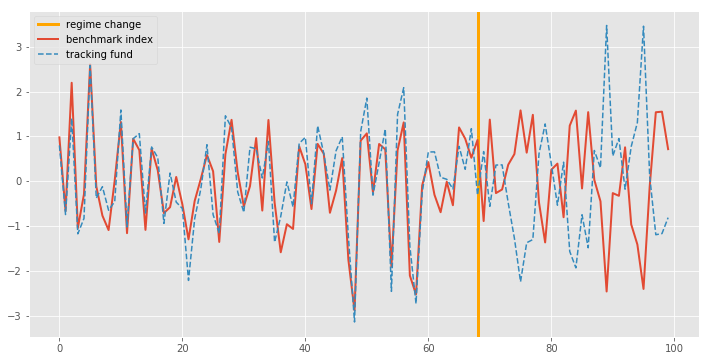

In [40]:
benchmark = np.random.normal(size=(100,1)) # some benchmark index
tracking = benchmark.copy() + .5*np.random.normal(size=(100,1)) # fund tracking benchmark
tracking[68:] = -1*tracking[68:] # flip relationship at day 68

plt.figure(figsize=(12, 6))
plt.axvline(x=68, color = 'orange', label='regime change', linewidth=3)
plt.plot(benchmark, label='benchmark index', linewidth=2)
plt.plot(tracking, label='tracking fund', linestyle='--')
plt.legend()
plt.show()

We can estimate when this regime change occurred using the `kernel_split` method:

In [41]:
data = np.hstack((benchmark, tracking))
rg.kernel_split(
    time_series=data,
    metric=rg.METRICS['correlation'],
    kernel=rg.KERNELS['gaussian'],
    bandwidth=20,
    pad=10
)

# 68

68

Another example is with the metric tracking error. We'll generate data where one time series tacks the other well then suddenly tracks poorly starting on day 40.

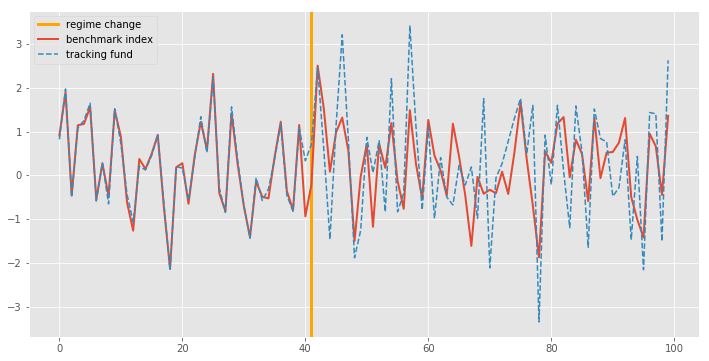

In [42]:
benchmark = np.random.normal(size=(100,1)) # some benchmark index
tracking = benchmark.copy() + .1*np.random.normal(size=(100,1)) # fund tracking benchmark
tracking[40:] = tracking[40:] + np.random.normal(size=(60,1)) # tracking error blows up at day 40

plt.figure(figsize=(12, 6))
plt.axvline(x=41, color = 'orange', label='regime change', linewidth=3)
plt.plot(benchmark, label='benchmark index', linewidth=2)
plt.plot(tracking, label='tracking fund', linestyle='--')
plt.legend()
plt.show()

We can again estimate when this regime change occured using the `kernel_split` method:

In [47]:
data = np.hstack((benchmark, tracking))
rg.kernel_split(
    time_series=data,
    metric=rg.METRICS['tracking error'],
    kernel=rg.KERNELS['hyperbolic'],
    bandwidth=5,
    pad=10
)

# 40

40

### Speed Test

In [48]:
%timeit rg.kernel_split(\
    time_series=data,\
    metric=rg.METRICS['tracking error'],\
    kernel=rg.KERNELS['hyperbolic'],\
    bandwidth=10,\
    pad=10\
)

100 loops, best of 3: 7.83 ms per loop
